# Quantum GANs
Implementation with Qiskit and PyTorch

In [71]:
import copy
import numpy as np
import scipy.sparse as sps
np.set_printoptions(precision=2)

import torch
from torch.autograd import Function
import torch.nn as nn
import torch.optim as optim

import qiskit
from qiskit.visualization import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
sns.set(rc={'figure.figsize':(15, 6)})

In [ ]:
class _Base:
    def __init__(self, all_qubits, n_qubits, n_layers, layer_format):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.circuit = qiskit.QuantumCircuit(all_qubits, 1)
        self.params = {}
        
        self.layer_format = layer_format
        for layer in range(n_layers):
            self._create_layer(layer)
        
        self._init_param_values()
        
    def _generate_pairs(self, n_qubits):
        pairs = [(i, i + 1) for i in range(n_qubits - 1)]
        pairs.append((n_qubits - 1, 0))
        return pairs
    
    def _init_param_values(self):
        self.params_vals = np.array([])
        for key in self.params.keys():
            random = np.random.random() * np.pi
            self.params_vals = np.append(self.params_vals, random)
        
    def _create_layer(self, layer):
        # Insert RZ, RX, RZ rotation on each qubit
        for qubit in range(self.n_qubits):
            key = self.layer_format.format(layer, qubit)
            self.params[key] = qiskit.circuit.Parameter(key)
            self.circuit.ry(self.params[key], qubit)
        
        # Entangle qubits
        if layer != self.n_layers - 1:
            for qubit_1, qubit_2 in self._generate_pairs(self.n_qubits):
                self.circuit.cz(qubit_1, qubit_2)
            self.circuit.barrier()
        
    def _bind_parameters(self, values):
        parameter_binds = {}
        for key, value in zip(list(self.params.keys()), values):
            parameter_binds[self.params[key]] = value
        return parameter_binds

    
    def __call__(self, params=None):
        if params is None:
            params = self.params_vals
        job = qiskit.execute(self.circuit, self.backend, shots=self.iterations,
                             parameter_binds=[self._bind_parameters(params)])

        result = job.result().get_counts(self.circuit)

        counts = np.array(list(result.values()))
        states = [int(key.split(' ')[0], 2) for key in np.array(list(result.keys()))]

        probabilities = np.zeros(2 ** len(self.circuit.qubits)) 
        probabilities[states] = counts
        probabilities /= self.iterations

        return np.array(probabilities)

In [ ]:
class RealCircuit(_Base):
    def __init__(self, backend, iterations, n_qubits):
        super().__init__(n_qubits, n_qubits - 1, 1, "r{}{}")
        self.backend = backend
        self.iterations = iterations
        self.circuit.barrier()

class GeneratorCircuit(_Base):
    def __init__(self, backend, iterations, n_qubits, n_layers):
        super().__init__(n_qubits, n_qubits - 1, n_layers, "g{}{}")
        self.backend = backend
        self.iterations = iterations
        self.circuit.barrier()

class DisciminatorCircuit(_Base):
    def __init__(self, backend, iterations, n_qubits, n_layers):
        super().__init__(n_qubits, n_qubits, n_layers, "d{}{}")        
        self.backend = backend
        self.iterations = iterations
        self.circuit.measure(n_qubits - 1, 0)

In [73]:
class GANCircuit(_Base):
    def __init__(self, generator, discriminator):
        super().__init__(discriminator.n_qubits, 0, 0, None)
        
        self.generator = generator
        self.discriminator = discriminator
        
        self.circuit = generator.circuit.combine(discriminator.circuit)
        
        self.params = {
            "source": data_source.params,
            "discriminator": self.params
        }
        self.params_vals = {
            "source": self.params_vals,
            "discriminator": data_source.params_vals
        }
        
    @property
    def n_params_source(self):
        return len(self.params["source"])
    
    @property
    def n_params_discriminator(self):
        return len(self.params["discriminator"])
    
    @property
    def get_params_source_name(self):
        return list(self.params["source"].keys())
    
    @property
    def get_params_discriminator_name(self):
        return list(self.params["discriminator"].keys())
    
    def _bind_parameters(self, values):
        print(self.get_params_source_name)
        params_s = {}
        for key, value in zip(self.get_params_source_name, 
                              values[:self.n_params_source]):
            params_s[self.params["source"][key]] = value
        params_d = {}
        for key, value in zip(list(self.params["discriminator"].keys()), 
                              values[self.n_params_source:]):
            params_s[self.params["discriminator"][key]] = value
        
        return {**params_s, **params_d}

#### Visualisation

In [74]:
n_qubits = 5
n_layers = 3

backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 1240

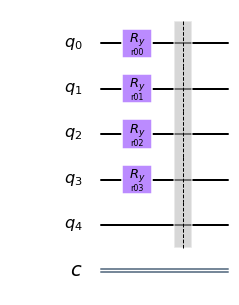

In [75]:
real_data = Real(backend, shots, n_qubits)
real_data.circuit.draw()

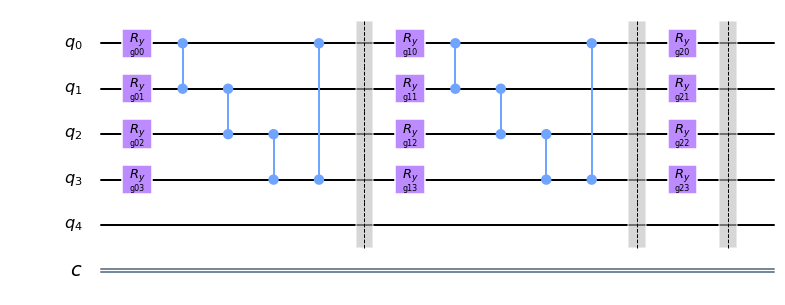

In [76]:
generated_data = Generator(backend, shots, n_qubits, n_layers)
generated_data.circuit.draw()

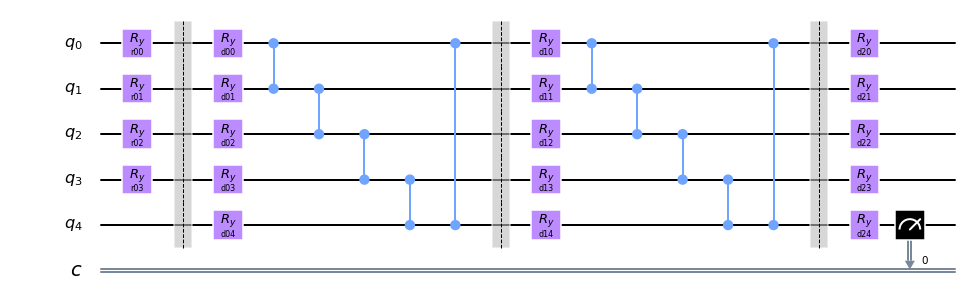

In [77]:
discriminator_real = Disciminator(backend, shots, n_qubits, n_layers)
discriminator_real.add_source(real_data)
discriminator_real.circuit.draw()

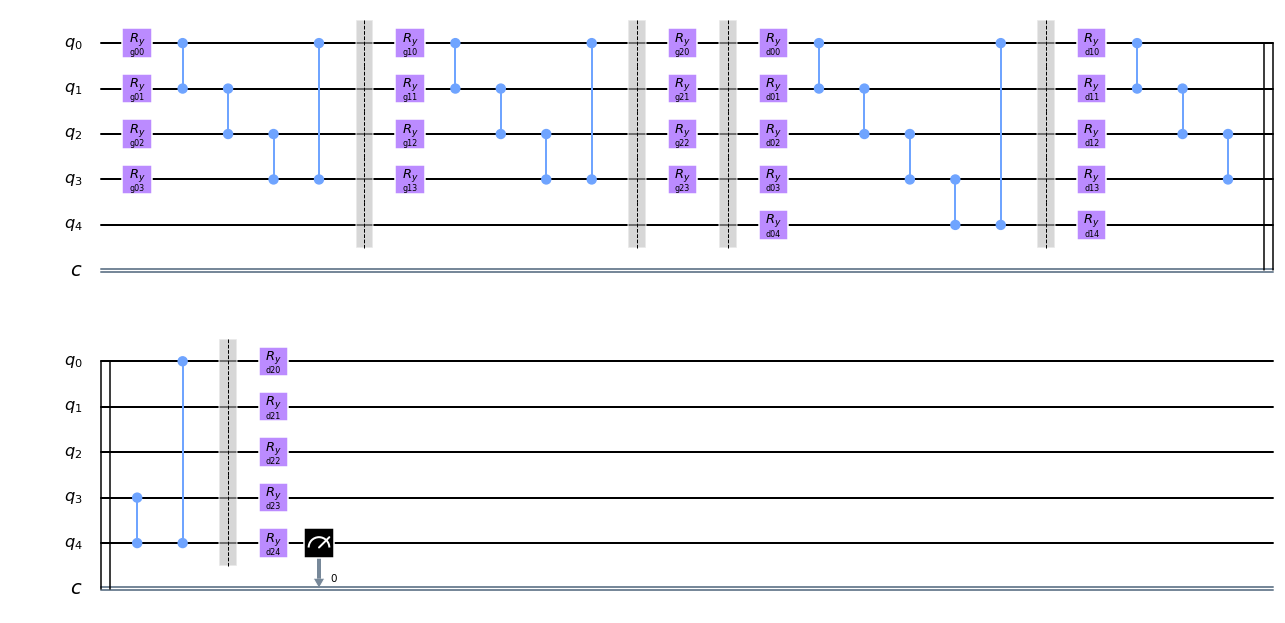

In [78]:
discriminator_gen = Disciminator(backend, shots, n_qubits, n_layers)
discriminator_gen.add_source(generated_data)
discriminator_gen.circuit.draw()

Text(0.5, 1.0, 'Target distribution')

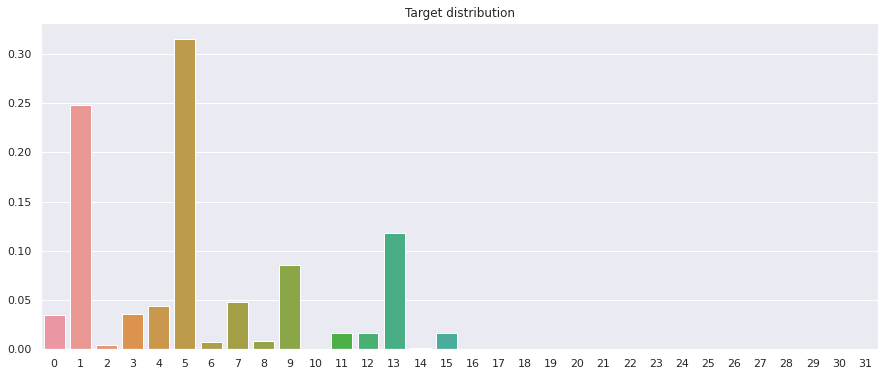

In [79]:
test = copy.deepcopy(real_data)
test.circuit.measure_all()

distribution = test()

sns.barplot(x = np.arange(len(distribution)), y = distribution)
plt.title("Target distribution")

Text(0.5, 1.0, 'Generated distribution')

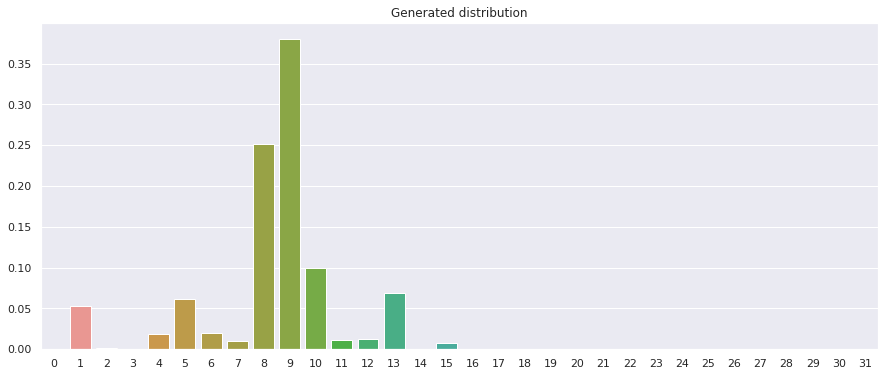

In [80]:
test = copy.deepcopy(generated_data)
test.circuit.measure_all()

distribution = test()

sns.barplot(x = np.arange(len(distribution)), y = distribution)
plt.title("Generated distribution")

### Defining custom PyTorch layers

In [81]:
class HybridFunction(Function):
    @staticmethod
    def forward(ctx, params, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        probabilities = ctx.quantum_circuit()
        result = torch.tensor([probabilities])
        ctx.save_for_backward(params, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        params, probabilities = ctx.saved_tensors
        params = np.array(params.tolist())
        
        shift_right = params + np.eye(len(params)) * ctx.shift / 2
        shift_left = params - np.eye(len(params)) * ctx.shift / 2

        gradients = []
        for i in range(len(params)):
            probs_right = ctx.model(shift_right[i])
            probs_left  = ctx.model(shift_left[i])
            
            gradient = probs_right - probs_left
            gradients.append(gradient)
        gradients = torch.tensor(gradients)
        chain_gradients = gradients.float() @ grad_output.float().T
        chain_gradients = torch.flatten(chain_gradients)
        return chain_gradients, None, None

class Generator(nn.Module):
    def __init__(self, model, shift):
        super(Generator, self).__init__()
        self.model = model
        self.shift = shift
        self.params = torch.nn.Parameter(torch.tensor(self.model.params_vals["source"]))
        
    def forward(self):
        self.model.source_params_vals = self.params.data.numpy()
        return HybridFunction.apply("source", self.model, self.shift)

class Discriminator(nn.Module):
    def __init__(self, model, shift):
        super(Discriminator, self).__init__()
        self.model = model
        self.shift = shift
        self.params = torch.nn.Parameter(torch.tensor(self.model.params_vals["discriminator"]))
        
    def forward(self):
        self.model.params_vals = self.params.data.numpy()
        return HybridFunction.apply("discriminator", self.model, self.shift)

#### Training

In [ ]:
model_gen = Generator(discriminator_gen, np.pi / 2)
model_dis_g = Discriminator(discriminator_gen, np.pi / 2)
model_dis_r = Discriminator(discriminator_real, np.pi / 2)

loss = nn.BCELoss()

real_label = 1
fake_label = 0

optimizer_gen = optim.Adam(model_gen.parameters(), lr=0.0002)
optimizer_dis = optim.Adam(model_dis_g.parameters(), lr=0.0002)

epochs = 100
losses_gen = []
losses_dis = []

model_gen.train()
model_dis_g.train()
model_dis_r.train()

for epoch in range(epochs):
    # ---------------------------
    # Train discriminator on real data
    model_dis_r.zero_grad()
    output = model_dis_r()
    loss_dis_r = loss(output, label)
    loss_dis_r.backward()
    optimizer_dis_r.step()
    # ---------------------------
    # Train discriminator on generated data
    model_dis_g.zero_grad()
    output = model_dis_g()
    loss_dis_g = loss(output, label)
    loss_dis_g.backward()
    optimizer_dis_g.step()
    # ---------------------------
    # Train generator
    model_gen.zero_grad()
    output = model_gen()
    loss_gen = loss(output, label)
    loss_gen.backward()
    optimizer_gen.step()
    # ---------------------------
    
    if epoch % 10 == 0:
        print('Training [\t{:.0f}%\t]\tLoss: {:.4f}'.format(
            100. * epoch / epochs, loss_list[-1].item()))

In [ ]:
plt.plot(loss_list)

In [ ]:
distribution = hybrid_model().detach().numpy()[0]
sns.barplot(x = np.arange(len(distribution)), y = distribution)